In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib.lines import Line2D
from pandas.tseries.offsets import MonthEnd
from sklearn.metrics import mean_absolute_percentage_error as mean_ape
from sklearn.metrics import root_mean_squared_error as root_mse

sns.set(style="white")

In [2]:
model_data_no_journal = pd.read_parquet("data/model_data_no_journal.parquet")
model_data_no_journal = model_data_no_journal[model_data_no_journal['political_alignment'] != 'autre']
model_data_no_journal['next_pres_votes_share'] = model_data_no_journal['pres_dummy'] * model_data_no_journal['pres_votes_share']

model_data = pd.read_parquet("data/model_data.parquet")
model_data = model_data[model_data['political_alignment'] != 'autre']
model_data['next_pres_votes_share'] = model_data['pres_dummy'] * model_data['pres_votes_share']

In [3]:
presi_dates = [
    "26/04/1981", "10/05/1981",
    "24/04/1988", "08/05/1988",
    "23/04/1995", "07/05/1995",
    "21/04/2002", "05/05/2002",
    "22/04/2007", "06/05/2007",
    "22/04/2012", "06/05/2012",
    "21/04/2017", "07/05/2017",
    "10/04/2022", "24/04/2022"]
presi_months = pd.to_datetime(presi_dates, dayfirst=True).to_period('M').drop_duplicates()

legi_dates = [
    "14/06/1981", "21/06/1981",
    "16/03/1986",
    "05/06/1988", "11/06/1988",
    "21/03/1993", "28/03/1993",
    "25/05/1997", "01/06/1997",
    "09/06/2002", "16/06/2002",
    "10/06/2007", "17/06/2007",
    "10/06/2012", "17/06/2012",
    "11/06/2017", "18/06/2017",
    "12/06/2022", "19/06/2022",
    "29/06/2024", "06/07/2024"]
legi_months = pd.to_datetime(legi_dates, dayfirst=True).to_period('M').drop_duplicates()

regio_dates = [
    "16/03/1986",
    "22/03/1992",
    "15/03/1998",
    "21/03/2004", "28/03/2004",
    "14/03/2010", "21/03/2010",
    "06/12/2015", "13/12/2015",
    "20/06/2021", "27/06/2021"]
regio_months = pd.to_datetime(regio_dates, dayfirst=True).to_period('M').drop_duplicates()

canto_dates = [
    "14/03/1982", "21/03/1982",
    "10/03/1985", "17/03/1985",
    "25/09/1988", "02/10/1988",
    "20/03/1992", "27/03/1992",
    "15/03/1998", "22/03/1998",
    "11/03/2001", "18/03/2001",
    "21/03/2004", "28/03/2004",
    "9/03/2008", "16/03/2008",
    "20/03/2011", "27/03/2011"]
canto_months = pd.to_datetime(canto_dates, dayfirst=True).to_period('M').drop_duplicates()

dept_dates = [
    "22/03/2015", "29/03/2015",
    "20/06/2021", "27/06/2021"]
dept_months = pd.to_datetime(dept_dates, dayfirst=True).to_period('M').drop_duplicates()

muni_dates = [
    "06/03/1983", "13/03/1983",
    "12/03/1989", "19/03/1989",
    "11/06/1995", "18/06/1995",
    "11/03/2001", "18/03/2001",
    "09/03/2008", "16/03/2008",
    "23/03/2014", "30/03/2014",
    "15/03/2020", "28/06/2020"]
muni_months = pd.to_datetime(muni_dates, dayfirst=True).to_period('M').drop_duplicates()

europ_dates = [
    "13/06/1999",
    "13/06/2004",
    "07/06/2009",
    "25/05/2014",
    "26/05/2019",
    "09/06/2024"]
europ_months = pd.to_datetime(europ_dates, dayfirst=True).to_period('M').drop_duplicates()

main_elec_dates = presi_dates + legi_dates + europ_dates
main_elec_months = pd.to_datetime(main_elec_dates, dayfirst=True).to_period('M').drop_duplicates().sort_values()

other_elec_dates = regio_dates + canto_dates + dept_dates + muni_dates
other_elec_months = pd.to_datetime(other_elec_dates, dayfirst=True).to_period('M').drop_duplicates().sort_values()

def add_shaded_periods(ax_list, periods, color, alpha):
    start_period = None
    for i, period in enumerate(periods):
        if start_period is None:
            start_period = period
        is_last = (i == len(periods) - 1)
        is_gap = (not is_last and periods[i + 1] != period + 1)
        if is_last or is_gap:
            end_period = period
            start = start_period.to_timestamp()
            end = (end_period + MonthEnd(1)).to_timestamp()
            for ax in ax_list:
                ax.axvspan(start, end, color=color, alpha=alpha)
            start_period = None

Ce notebook utilise une approche économétrique particulière, ne cherchant pas à modéliser le plus précisément possible les comportements réels, mais étudiant leur écart à des comportements théoriques. 

Elle est intéressant ici car les activités journalistiques sont fortement normées : il s'agit donc de modéliser les comportements prescrits par ces normes afin de vérifier si elles sont respectées, et sinon, de quelle manière les journalistes y dérogent.

Ce notebook utilise une approche économétrique étudiant l'écart entre des comportements théoriques et réels. Elles conçoit les comportements théoriques comme des normes, et leur écart avec les comportements réels comme une mesure de la déviance. Cette approche est intéressante lorsque les normes sont connues *a priori* et modélisables directement.

Prenons l'exemple du nombre d'articles consacrés aux différentes nuances politiques. Une ancienne règle éditoriale stipule que ces articles doivent se répartir au tiers entre le gouvernement, la majorité et l'opposition. Il est alors possible, plutôt que de modéliser la répartition réelle des articles, d'observer comment elle s'écarte de cette norme, en particulier selon les nuances politiques et au cours du temps. L'hypothèse d'une légitimation de l'extrême droite devrait se traduire par une application de moins en moins stricte de la règle des tiers. Ceci n'est en réalité pas vérifiable, car la règle des tiers amalgame l'ensemble des nuances politiques ne participant ni à la majorité ni au gouvernement, aboutissant à diluer l'extrême droite dans l'opposition.

Lorsque la norme n'est pas suffisamment connue pour être modélisable directement, il est possible de l'estimer à partir des données. Il existe ici un risque que le raisonnement deviennet circulaire : lorsque l'on mesure l'écart des comportements réels à une norme définie à partir des comportements moyens, on peut aboutir à évaluer plutôt la performance prédictive du modèle. Pour minimiser ce risque, il faut utiliser le modèle le plus simple possible, notamment en éliminant les contrôles.

# 1. Estimation de la norme
Appliquons cette approche à la proportion des citations attribuées à chaque nuance politique. Supposons que la couverture médiatique d'une nuance est fonction de sa représentativité politique réelle, reflétée par son score aux précédentes élections législatives et présidentielles, et son poids institutionnel, reflété par sa proportion de siège à l'Assemblée Nationale et sa participation au gouvernement.

$$Y_{i} = \beta T_{i} + \gamma G_{i} + \theta P_{i} + \delta L_{i}$$

Comme nous cherchons à isoler des évolutions au cours du temps, il est préférable d'estimer ces paramètres sur une période de référence, afin de vérifier si les résidus augmentent lors des périodes suivantes. Nous avons retenu la charnière de juin 2012.

*changer d'approche: ne plus estimer la norme, supposer une représentativité parfaite en fonction des sièges à l'assemblée.*

In [5]:
outcome = "quotes_share"
regressor = ["na_share", "pres_votes_share"]
regressors = ["leg_votes_share", "na_share", "pres_votes_share", "government"]

In [15]:
y = model_data_no_journal[outcome]
y_pred = (0.7 * model_data_no_journal["na_share"]) + (0.3 * model_data_no_journal["pres_votes_share"])
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

MAPE: 63.95%
RMSPE: 0.34548


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
sns.regplot(
    x=regressor,
    y=outcome,
    data=model_data_no_journal,
    scatter_kws={'color': 'steelblue', 'alpha': 0.4},
    line_kws={'color': 'royalblue', 'linestyle': 'dashdot', 'linewidth': 2}
)

min_val = min(model_data_no_journal[regressor].min(), model_data_no_journal[outcome].min())
max_val = max(model_data_no_journal[regressor].max(), model_data_no_journal[outcome].max())
plt.plot([min_val, max_val], [min_val, max_val], color='crimson', linestyle='--', label='45° line (y = x)')

plt.xlabel(regressor)
plt.ylabel(outcome)
plt.title(f"{outcome} vs {regressor} with Regression Line and 45° Reference")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
X = model_data_no_journal[regressor]
X = sm.add_constant(X)
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')

y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                      coef          pval
const             0.014612  1.603402e-13
na_share          0.728261  0.000000e+00
pres_votes_share  0.291419  1.564277e-56

MAPE: 77.86%
RMSPE: 0.33126


In [17]:
X = model_data_no_journal[regressors]
X = sm.add_constant(X)
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')

y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                      coef           pval
const             0.012052   5.073930e-11
leg_votes_share   0.511324   6.017182e-43
na_share          0.484610  2.917317e-252
pres_votes_share  0.114102   3.112526e-06
government        0.077609   7.463840e-34

MAPE: 70.59%
RMSPE: 0.30481


Réduire les données à la période antérieure à juin 2017 exerce un effet ambigu sur les performances du modèle : les écarts absolus augmentent mais les écarts quadratiques se réduisent, ce qui signifie que les valeurs courantes sont moins bien prédites, tandis que les outliers sont mieux prédits.

Le score aux prochaines élections présidentielles n'est pas significatif. Nous conservons néanmoins cette variable dont nous avons vu qu'elle est intéressante seulement pour les nuances extrêmes.

# 2. Mesure des écarts
## Selon les partis politiques

In [ ]:
# model_data_no_journal['y_pred'] = model.predict(model_data_no_journal[regressors])
# model_data_no_journal['rel_residuals'] = 100 * (model_data_no_journal[outcome] - model_data_no_journal['y_pred']) / model_data_no_journal[outcome]

In [28]:
model_data_no_journal['y_pred'] = 0.01 + (0.695 * model_data_no_journal["na_share"]) + (0.295 * model_data_no_journal["pres_votes_share"])
model_data_no_journal['rel_residuals'] = 100 * (model_data_no_journal[outcome] - model_data_no_journal['y_pred']) / model_data_no_journal[outcome]

In [29]:
summary = []

for alignment in model_data_no_journal['political_alignment'].unique():
    subset_data = model_data_no_journal[model_data_no_journal['political_alignment'] == alignment]
    y = subset_data[outcome]
    y_pred = subset_data['y_pred']
    mape = mean_ape(y, y_pred)
    rmspe = root_mse(y, y_pred) / y.mean()
    summary.append({
        'Political alignment': alignment,
        'MAPE': mape,
        'RMSPE': rmspe
    })

pd.DataFrame(summary).style.hide(axis=0)

Political alignment,MAPE,RMSPE
Center,1.439431,0.669302
Right,0.188639,0.184994
Left,0.262258,0.267118
Far right,0.517216,0.628219
Far left,1.150557,0.839453


In [30]:
cutoff1 = pd.Period('2002-06', freq='M')
cutoff2 = pd.Period('2017-06', freq='M')

models = {}

for period_label, period_filter in {
    '1981-2002': model_data_no_journal["month"] < cutoff1,
    '2002-2017': (model_data_no_journal["month"] >= cutoff1) & (model_data_no_journal["month"] < cutoff2),
    '2017-2024': model_data_no_journal["month"] >= cutoff2
}.items():
    
    models[period_label] = {}
    period_data = model_data_no_journal[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        models[period_label][alignment] = {}
        subset = period_data[period_data["political_alignment"] == alignment]

        if len(subset) >= 3:
            y = subset[outcome]
            y_pred = subset['y_pred']
            mape = mean_ape(y, y_pred)
            rmspe = root_mse(y, y_pred) / y.mean()

            models[period_label][alignment] = {
                "mape": mape,
                "rmspe": rmspe}

        else:
            models[period_label][alignment] = {
                "mape": None,
                "rmspe": None}

In [31]:
nuances_order = ["Far right", "Right", "Center", "Left", "Far left"]

summary_list = []

for period, alignment_dict in models.items():
    for alignment, model_info in alignment_dict.items():
        summary_list.append({
            "period": period,
            "alignment": alignment,
            "mape": model_info["mape"],
            "rmspe": model_info["rmspe"]
        })

summary = pd.DataFrame(summary_list)
summary["alignment"] = pd.Categorical(summary["alignment"], categories=nuances_order, ordered=True)
summary = summary.pivot_table(index="alignment",
                                      columns="period",
                                      values=["mape", "rmspe"],
                                      observed=False)
summary = summary.reset_index()
summary.columns.names = [None, None]

format_cols = summary.columns[1:]
summary.style.hide(axis="index").format({col: "{:.3f}" for col in format_cols})

In [32]:
plot_data = model_data_no_journal.copy()
plot_data['month'] = plot_data['month'].dt.to_timestamp()

alignment_groups = [
    (['Far left', 'Far right'],
     {'Far left': 'crimson',
      'Far right': 'royalblue'}),
    (['Right', 'Left', 'Center'],
     {'Right': 'cornflowerblue',
      'Left': 'orchid',
      'Center': 'goldenrod'})]

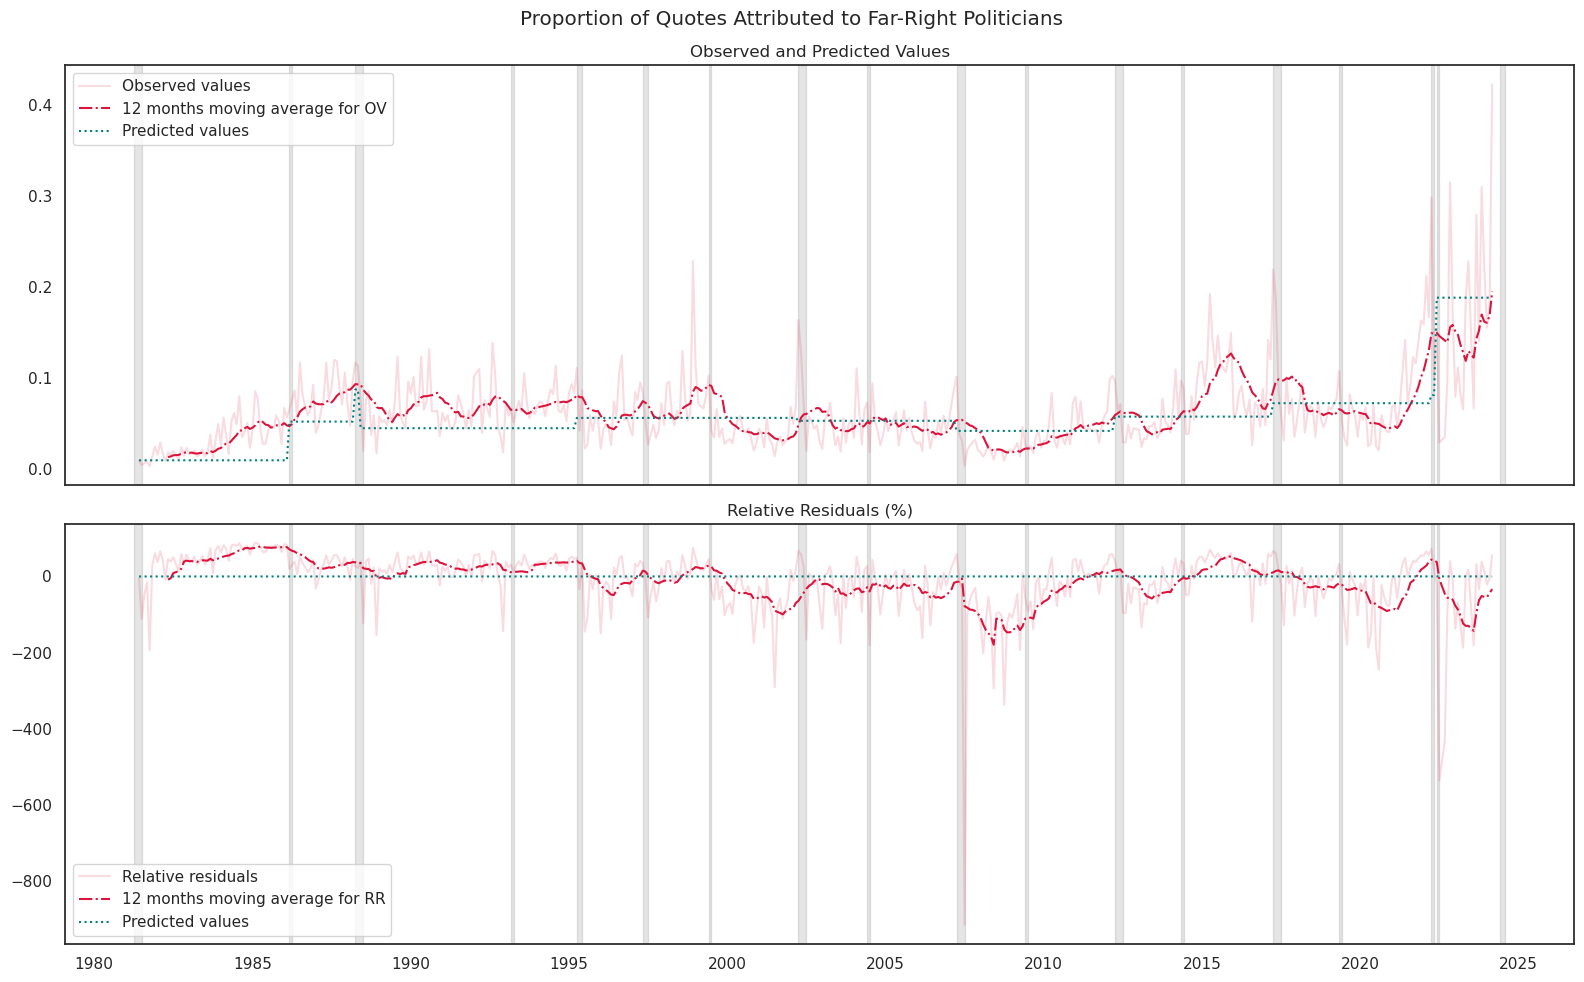

In [33]:
alignment = 'Far right'
subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
subset_data['MA_observed'] = subset_data[outcome].rolling(window=12).mean()
subset_data['MA_rel'] = subset_data['rel_residuals'].rolling(window=12).mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

sns.lineplot(data=subset_data, x='month', y=outcome, ax=axes[0], label='Observed values', alpha=0.15, color='crimson', linestyle='-')
sns.lineplot(data=subset_data, x='month', y='MA_observed', ax=axes[0], label='12 months moving average for OV', color='crimson', linestyle='dashdot')
sns.lineplot(data=subset_data, x='month', y='y_pred', ax=axes[0], label='Predicted values', color='teal', linestyle='dotted')
axes[0].set_title("Observed and Predicted Values")
axes[0].set_ylabel('')

sns.lineplot(data=subset_data, x='month', y='rel_residuals', ax=axes[1], label='Relative residuals', alpha=0.15, color='crimson', linestyle='-')
sns.lineplot(data=subset_data, x='month', y='MA_rel', ax=axes[1], label='12 months moving average for RR', color='crimson', linestyle='dashdot')
sns.lineplot(data=subset_data, x='month', y='y_pred', ax=axes[1], label='Predicted values', color='teal', linestyle='dotted')
axes[1].set_title("Relative Residuals (%)")
axes[1].set_xlabel('')
axes[1].set_ylabel('')

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Proportion of Quotes Attributed to Far-Right Politicians")
plt.tight_layout()
plt.show()

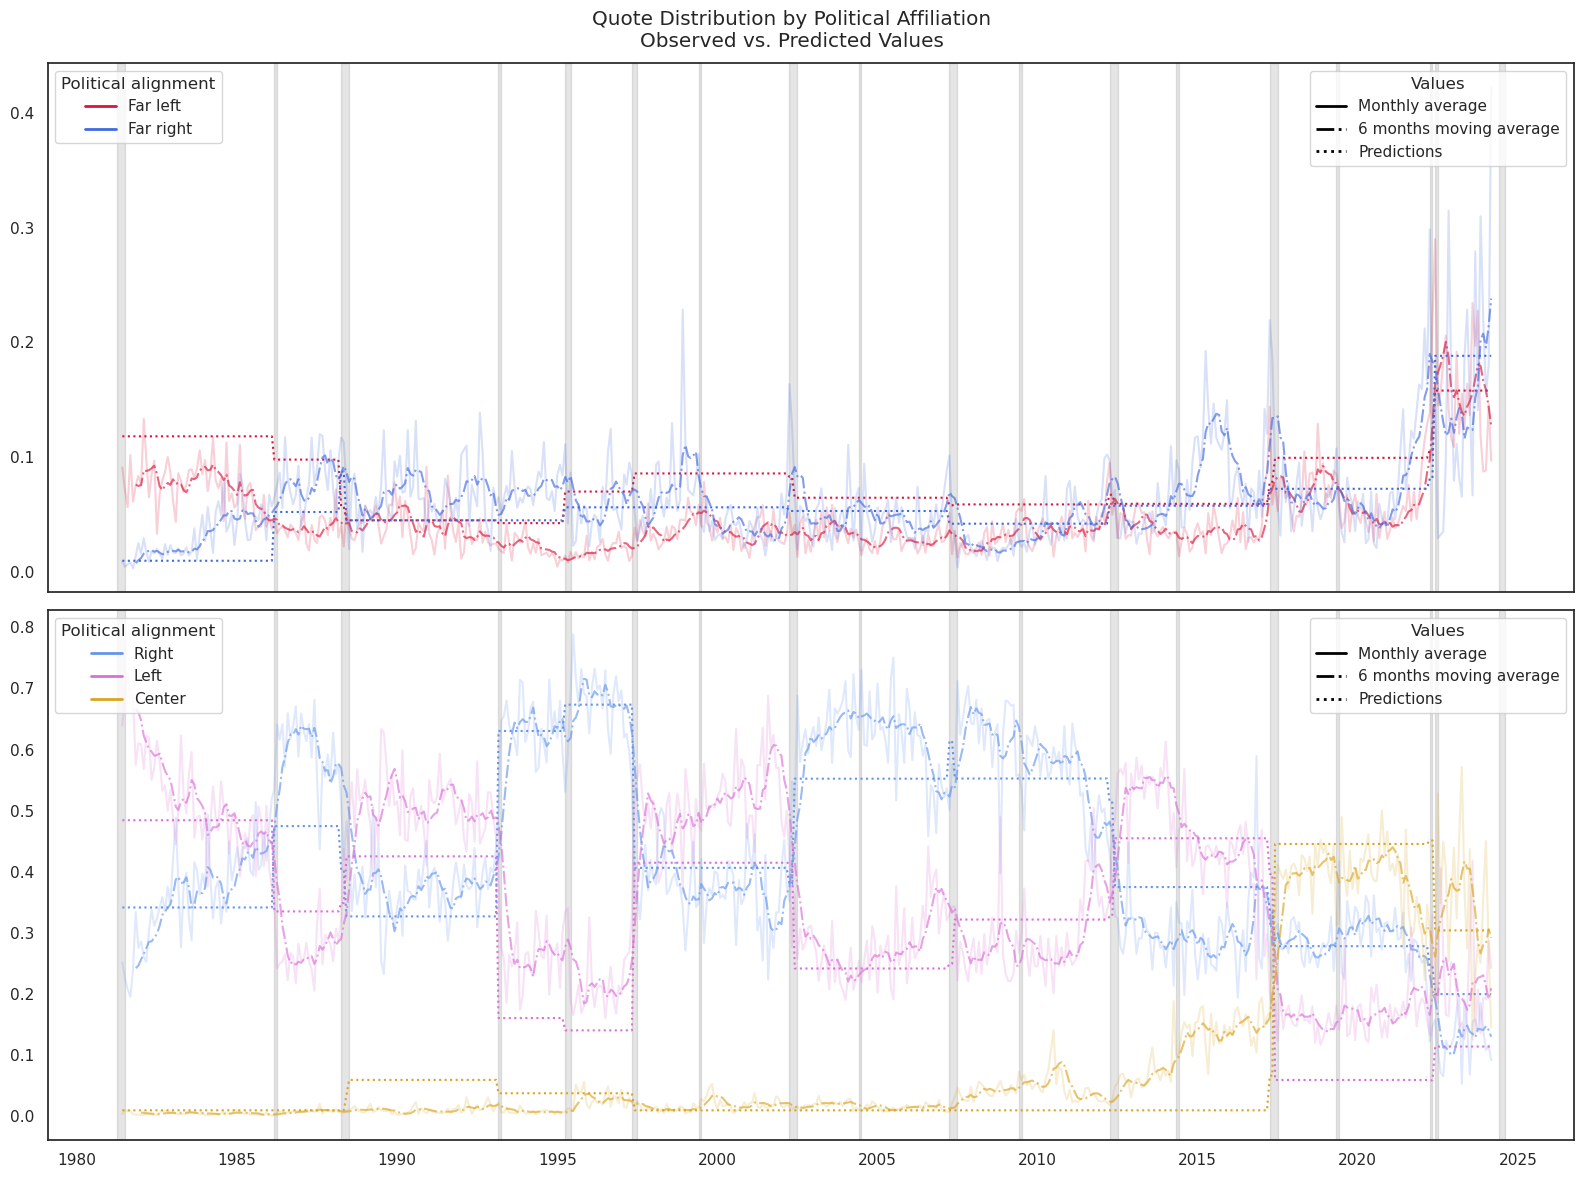

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data[outcome].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data[outcome], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='dashdot')
        ax.plot(subset_data['month'], subset_data['y_pred'], label=None,
                alpha=1, color=colors[alignment], linestyle='dotted')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='dashdot', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle='dotted', label="Predictions")]
    ax.legend(handles=line_type_handles, title="Values", loc="upper right")

axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nObserved vs. Predicted Values")
plt.tight_layout()
plt.savefig("output/nuances_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()

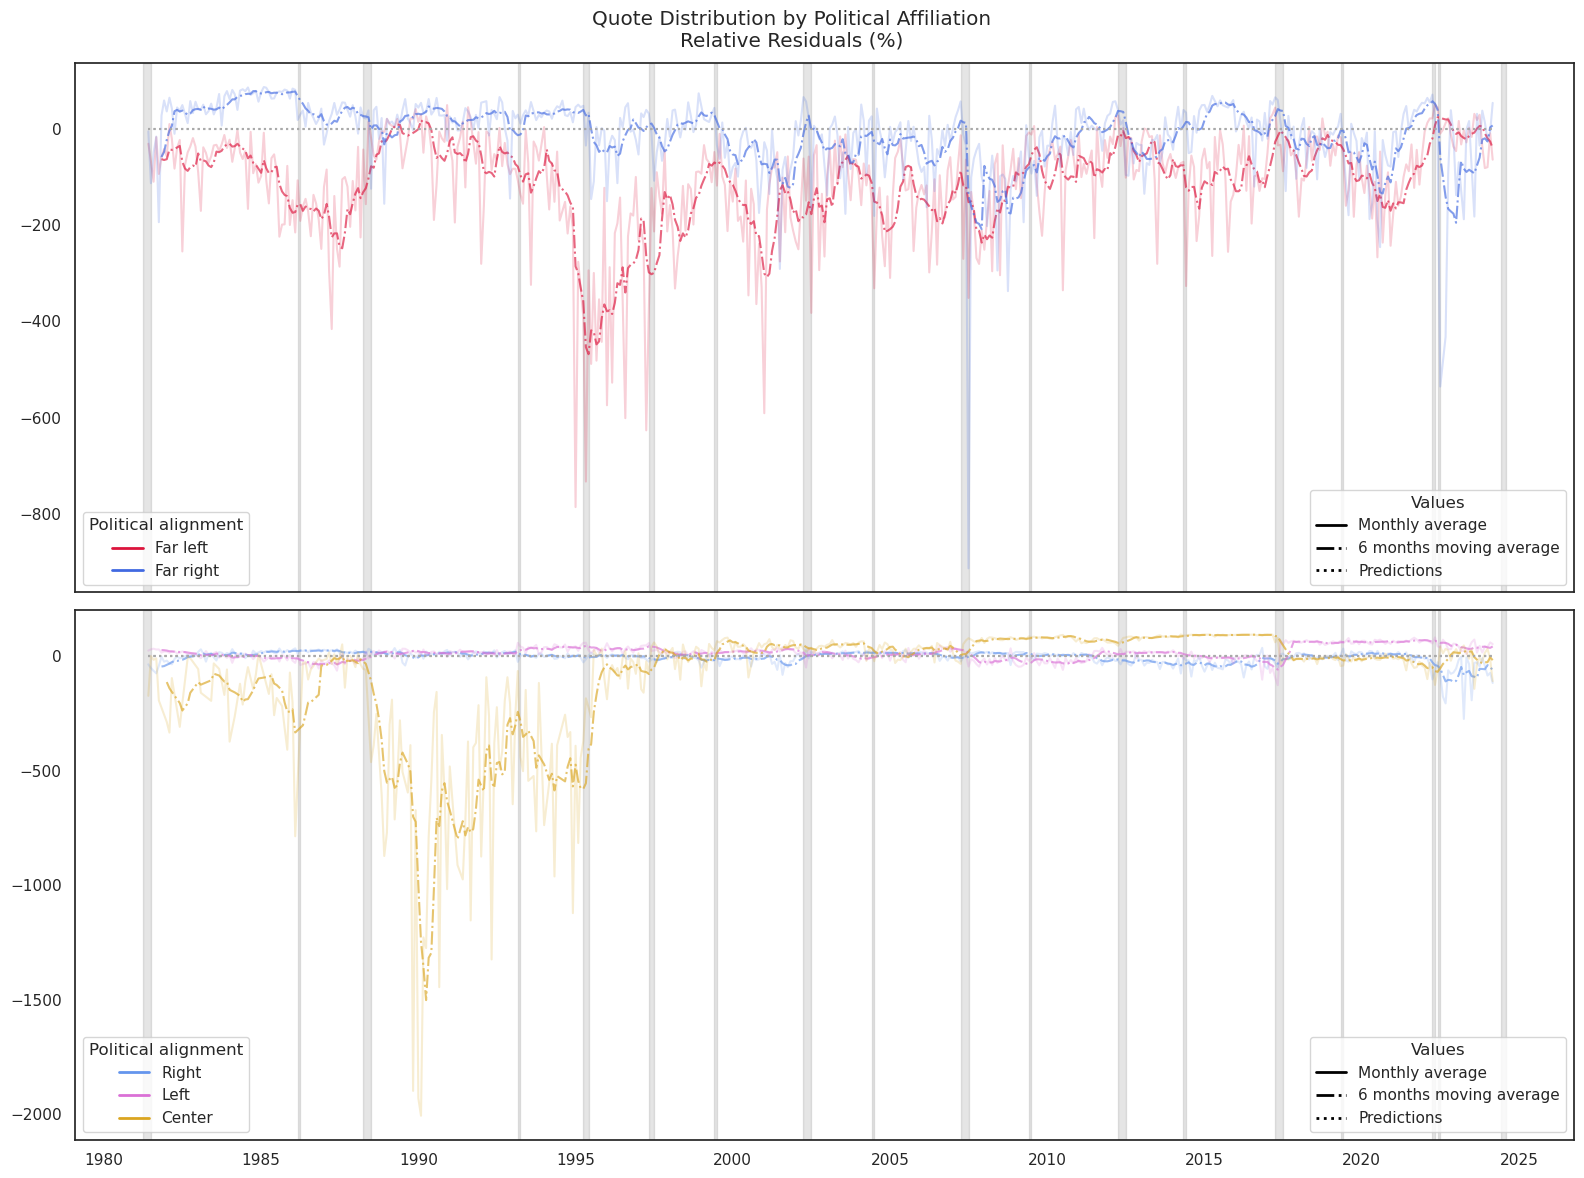

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data['rel_residuals'].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data['rel_residuals'], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='-.')
        ax.plot(subset_data['month'], [0] * len(subset_data), label=None,
                alpha=1, color='darkgray', linestyle=':')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="lower left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='-.', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle=':', label="Predictions")
    ]
    ax.legend(handles=line_type_handles, title="Values", loc="lower right")

axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nRelative Residuals (%)")
plt.tight_layout()
plt.savefig("output/nuances_res_graph.png", dpi=300, bbox_inches='tight')
plt.show()

On ne voit pas apparaître de tendance manifestement favorable à l'extrême droite.

In [27]:
model_data_no_journal[model_data_no_journal['political_alignment'] == 'Center'].head(n=10)

,month,political_alignment,quotes_nb,quotes_share,art_nb,art_share,mean_quote_length,type_direct_share,type_undirect_share,type_mixed_share,personalities_nb,leg_votes_share,na_share,pres_dummy,last_election,pres_votes_share,government,next_pres_votes_share,y_pred,rel_residuals
1,1981-06,Center,2183,0.003665,653,0.004594,159.750000,0.750000,0.125000,0.125000,2,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.366468
6,1981-07,Center,1696,0.010024,479,0.014614,118.941176,0.470588,0.117647,0.411765,3,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,1.002358
11,1981-08,Center,1041,0.008646,333,0.009009,93.111111,0.666667,0.111111,0.222222,2,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.864553
16,1981-09,Center,2296,0.009146,613,0.017945,154.857143,0.476190,0.380952,0.142857,3,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.914634
22,1981-10,Center,2638,0.003412,671,0.008942,98.555556,0.555556,0.222222,0.222222,5,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.341168
36,1982-01,Center,1935,0.002584,512,0.007812,164.800000,0.400000,0.400000,0.200000,3,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.258398
42,1982-02,Center,2167,0.002307,531,0.003766,187.400000,0.200000,0.200000,0.600000,2,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.230734
48,1982-03,Center,1955,0.005115,559,0.010733,155.500000,0.700000,0.100000,0.200000,5,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.511509
62,1982-06,Center,2450,0.002449,598,0.003344,120.333333,0.333333,0.333333,0.333333,2,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.244898
68,1982-07,Center,1526,0.003277,462,0.008658,158.800000,0.400000,0.200000,0.400000,3,0.0,0.0,0,1981-01-01,0.0,0,0.0,0.0,0.327654


## Selon les journaux

In [18]:
# model_data['y_pred'] = model.predict(model_data[regressors])
# model_data['rel_residuals'] = 100 * (model_data[outcome] - model_data['y_pred']) / model_data[outcome]

model_data['y_pred'] = (0.7 * model_data["na_share"]) + (0.3 * model_data["pres_votes_share"])
model_data['rel_residuals'] = 100 * (model_data[outcome] - model_data['y_pred']) / model_data[outcome]

In [19]:
summary = []

for journal in model_data['journal'].unique():
    subset_data = model_data[model_data['journal'] == journal]
    y = subset_data[outcome]
    y_pred = subset_data['y_pred']
    mape = mean_ape(y, y_pred)
    rmspe = root_mse(y, y_pred) / y.mean()
    summary.append({
        'Journal': journal,
        'MAPE': mape,
        'RMSPE': rmspe})

pd.DataFrame(summary).style.hide(axis=0)

Journal,MAPE,RMSPE
Le Figaro,0.717936,0.356882
Le Monde,0.581545,0.357014
La Croix,0.532831,0.379396
Libération,0.487649,0.393549
Médiapart,0.706674,0.734867


In [21]:
plot_data = model_data.copy()
plot_data['month'] = plot_data['month'].dt.to_timestamp()

colors = {
    'Le Figaro': 'goldenrod',
    'Libération': 'limegreen',
    'Le Monde': 'orchid',
    'La Croix': 'skyblue',
    'Médiapart': 'crimson'}

alignments = [
    "Far right",
    "Right",
    "Center",
    "Left",
    "Far left"]

n_alignments = len(alignments)

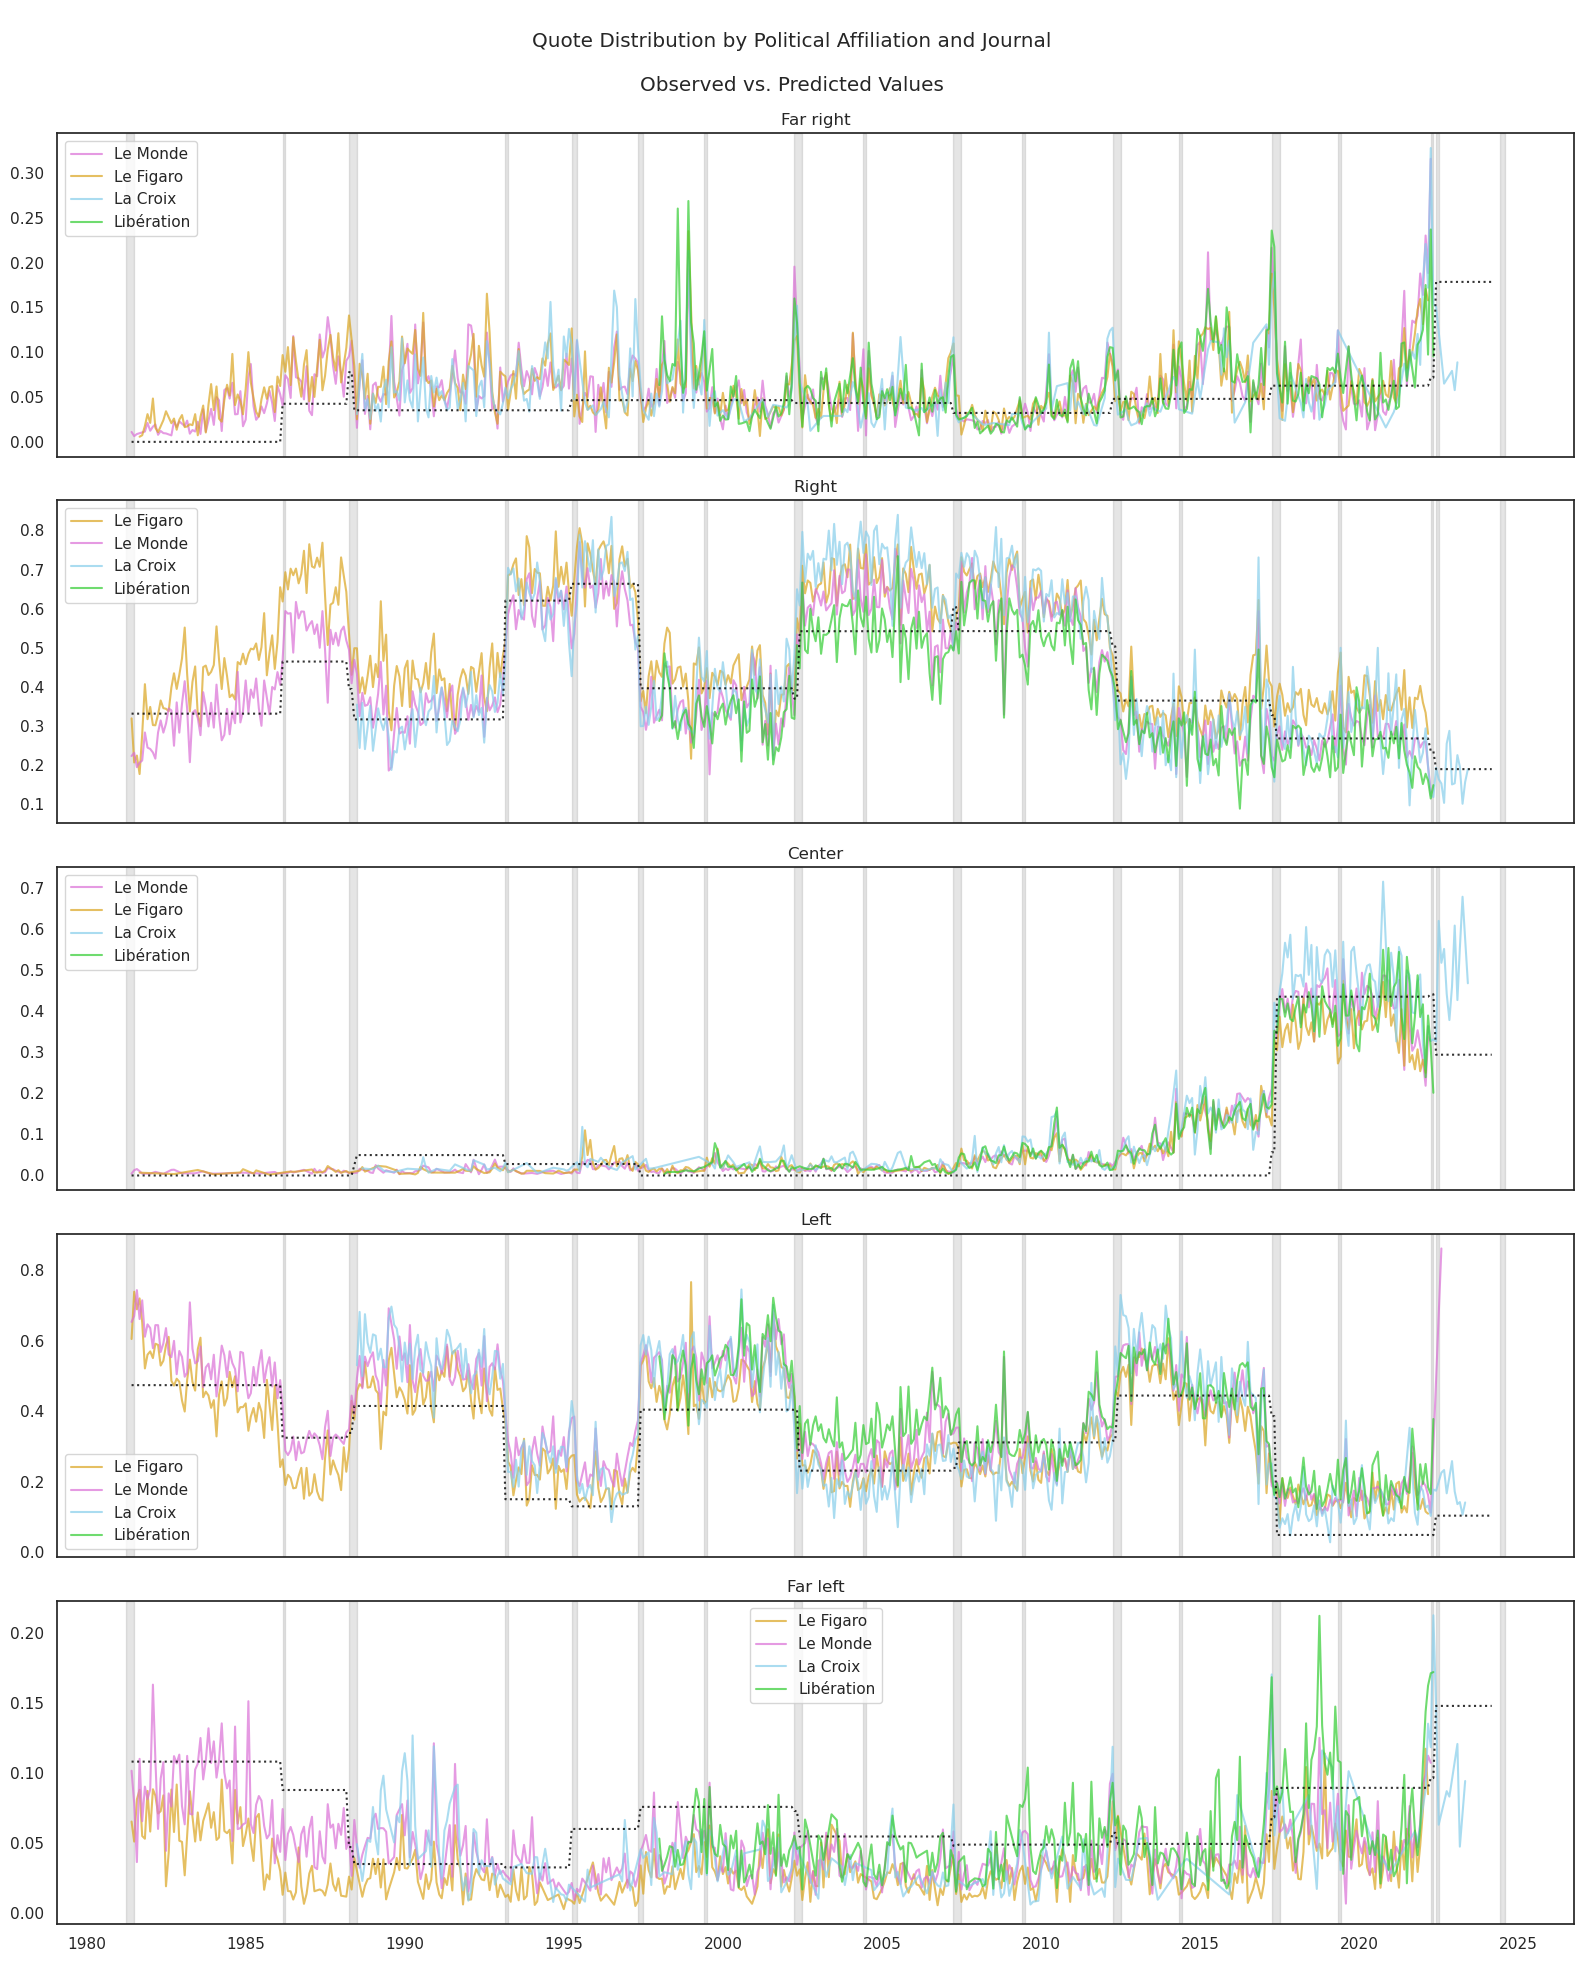

In [22]:
fig, axes = plt.subplots(n_alignments, 1, figsize=(16, 4 * n_alignments), sharex=True)

for i, alignment in enumerate(alignments):
    ax = axes[i]
    subset_data = plot_data[plot_data['political_alignment'] == alignment]

    for journal in subset_data['journal'].unique():
        if journal == 'Médiapart': continue
        sub_subset_data = subset_data[subset_data['journal'] == journal].copy()
        sub_subset_data['MA'] = sub_subset_data[outcome].rolling(window=12).mean()
        ax.plot(sub_subset_data['month'], sub_subset_data[outcome], label=journal,
                alpha=0.7, color=colors[journal], linestyle='-')

    ax.plot(subset_data['month'], subset_data['y_pred'], color='black', alpha=0.8, linestyle='dotted')
    ax.set_title(f"{alignment}")
    ax.legend()

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("""
Quote Distribution by Political Affiliation and Journal\n
Observed vs. Predicted Values
""")
plt.tight_layout()
plt.savefig("output/journals_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()

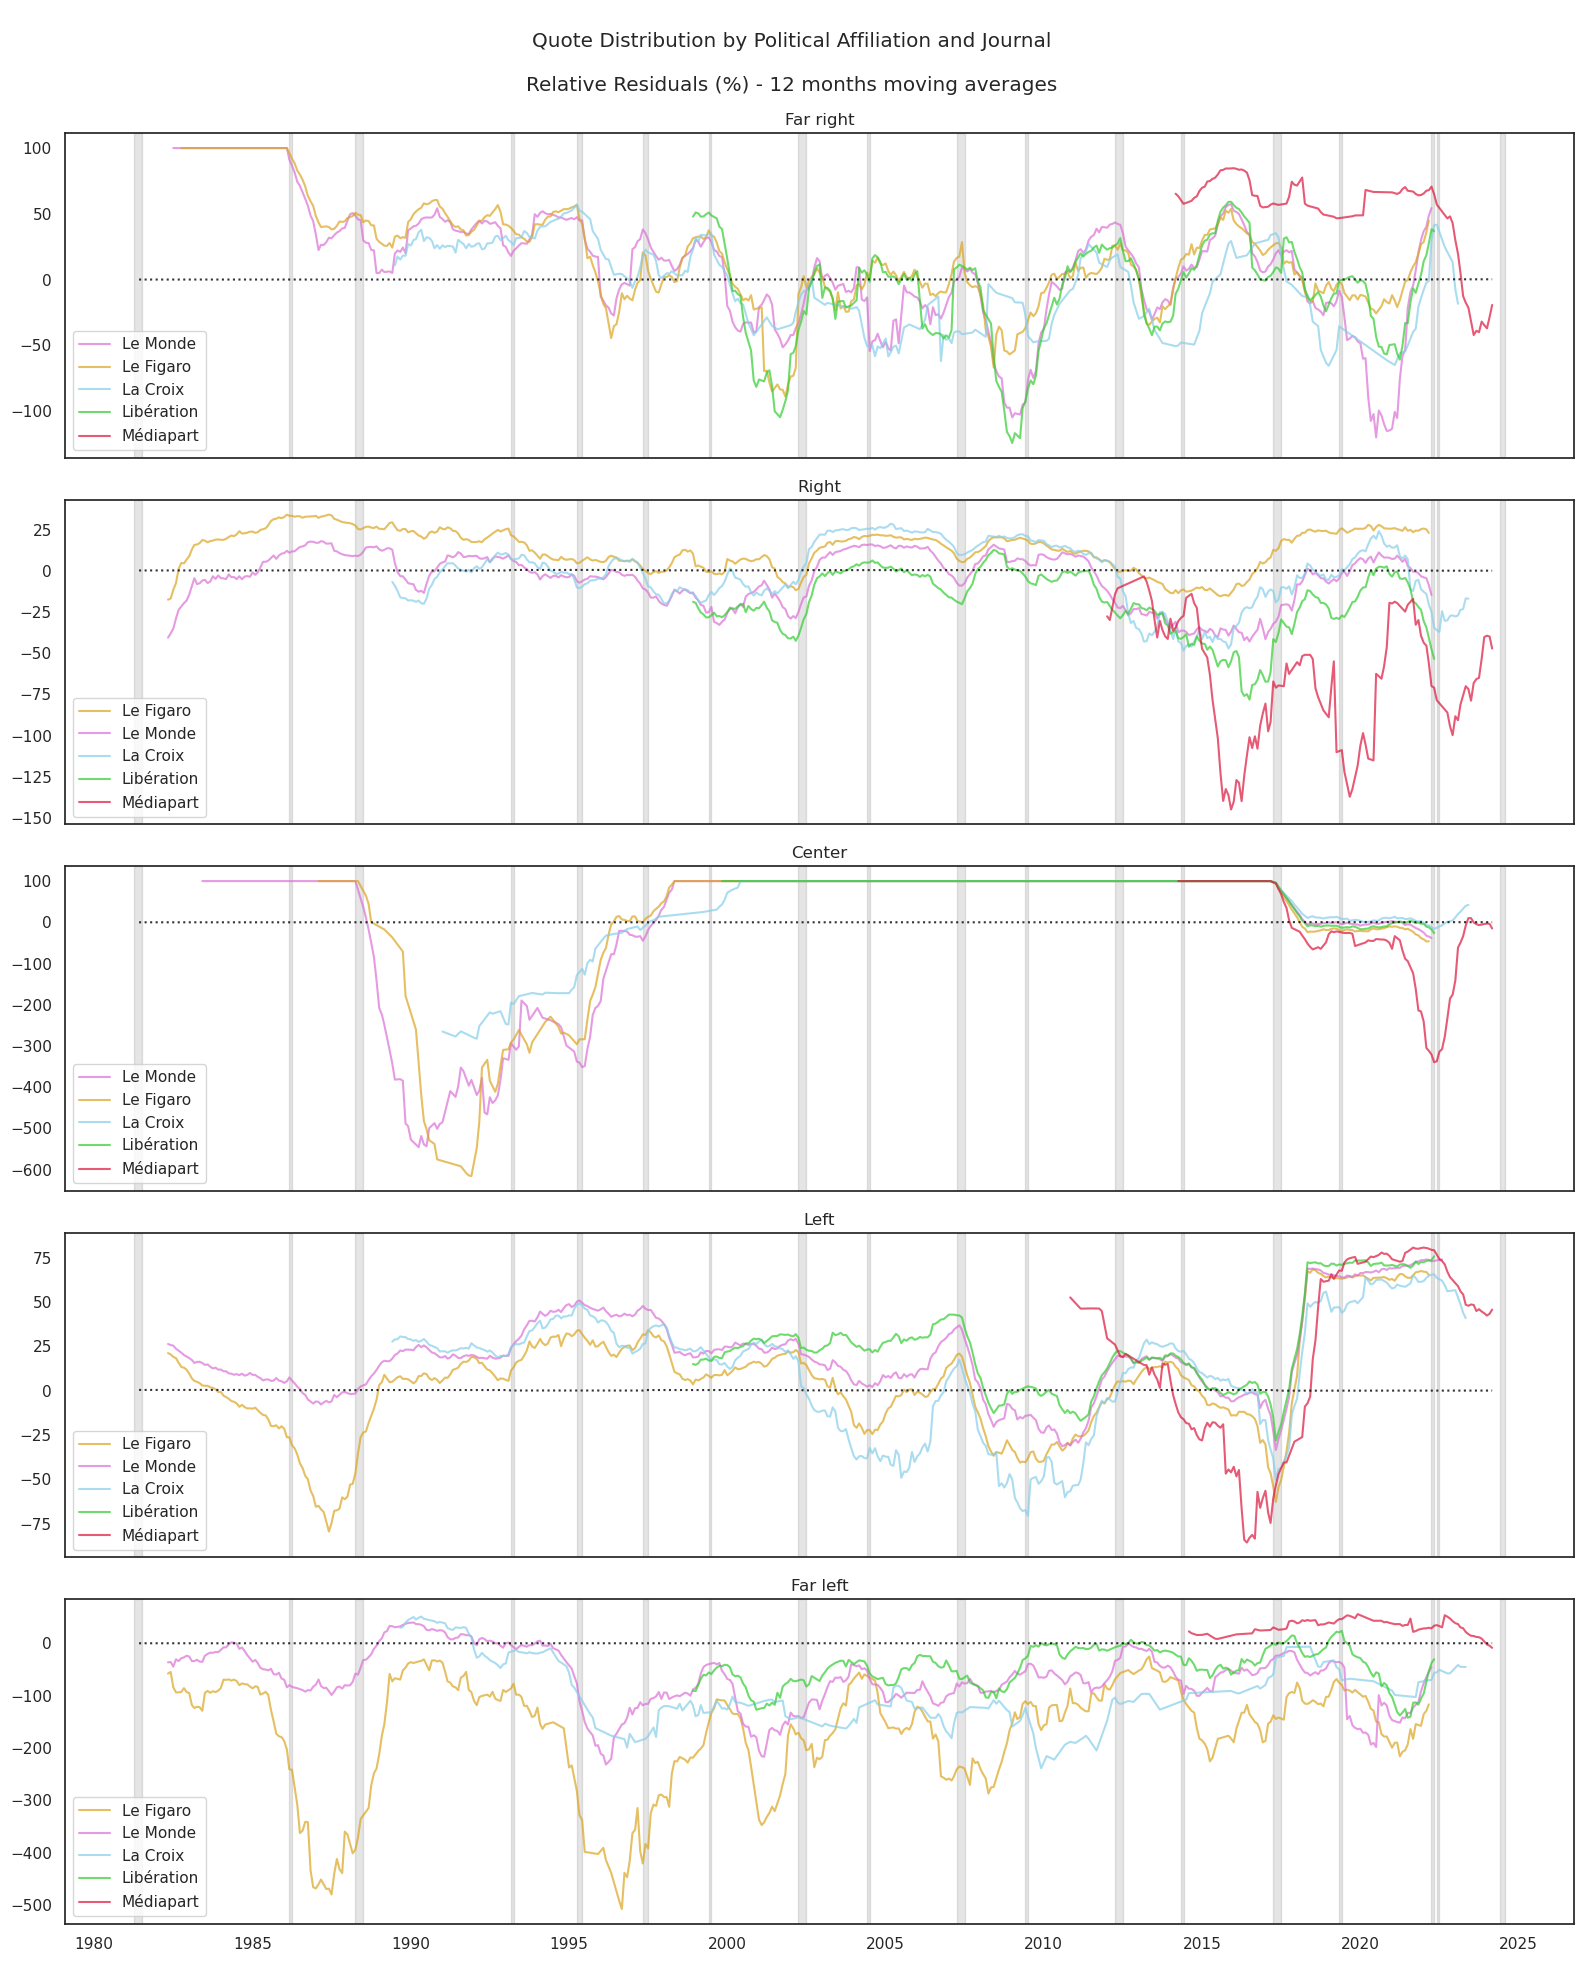

In [23]:
fig, axes = plt.subplots(n_alignments, 1, figsize=(16, 4 * n_alignments), sharex=True)

for i, alignment in enumerate(alignments):
    ax = axes[i]
    subset_data = plot_data[plot_data['political_alignment'] == alignment]

    for journal in subset_data['journal'].unique():
        sub_subset_data = subset_data[subset_data['journal'] == journal].copy()
        sub_subset_data['MA'] = sub_subset_data['rel_residuals'].rolling(window=12).mean()
        ax.plot(sub_subset_data['month'], sub_subset_data['MA'], label=journal,
                alpha=0.7, color=colors[journal], linestyle='-')

    ax.plot(subset_data['month'], subset_data['y_pred'], color='black', alpha=0.8, linestyle='dotted')
    ax.set_title(f"{alignment}")
    ax.legend()

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("""
Quote Distribution by Political Affiliation and Journal\n
Relative Residuals (%) - 12 months moving averages
""")
plt.tight_layout()
plt.savefig("output/journals_res_graph.png", dpi=300, bbox_inches='tight')
plt.show()

Les comportements des différents journaux relativement à l'extrême droite s'avèrent très proches.